In [62]:
import numpy as np
import keras as ks
import matplotlib.pyplot as plt

%matplotlib inline

The aim of generative adversarial networks is to obtain an estimation of the distribution $p_{data}$ over data $\textbf{x}$ using two competing neural networks. A generative model $G$ attempts to capture the data distribution, allowing it to create fake data points. A discriminative model $D$ obtains both fake samples from $G$ and real data samples and aims to estimate the probability that the sample is a real data point rather than obtained from $G$.

Let's define a distribution $p_{data}$ to approximate:

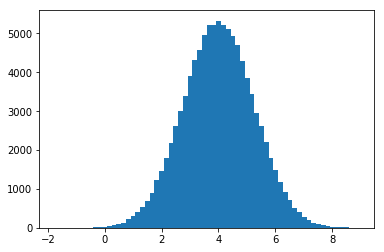

In [67]:
n = 1000  # Sample size

# Gaussian distribution with mean of 4 and standard deviation of 1.25
# Let x denote the number of data points that are sampled
p_data = lambda x: np.random.normal(loc=4, scale=1.25, size=(x, n))


def show_distribution(p):
    plt.hist(np.ravel(p(100)), bins=64)
    plt.show()
    

def show_distributions(ps, ls):
    assert len(ps) == len(ls)
    for p, l in zip(ps, ls):
        plt.hist(np.ravel(p(100)), bins=64, label=l)
    plt.legend()
    plt.show()

        

show_distribution(p_data)


To learn the generator's distribution $p_g$ over data $\textbf{x}$ a prior input noise variable $p_z(\textbf{z})$ is defined which is mapped to the data space by $G(\textbf{z};\theta_g)$, where $G$ is a differential function (neural network in this case) with parameters $\theta_g$. A second model $D(\textbf{x};\theta_d)$ represents the probability that $\textbf{x}$ came from the data distribution rather than $p_g$.

In [81]:
G = ks.models.Sequential()
G.add(ks.layers.Dense(50, activation='elu', input_shape=(n,)))
G.add(ks.layers.Dense(50, activation='elu'))
G.add(ks.layers.Dense(n, activation='linear'))
G.compile(optimizer='SGD',
          loss='binary_crossentropy')

D = ks.models.Sequential()
D.add(ks.layers.Dense(50, activation='elu', input_shape=(n,)))
D.add(ks.layers.Dense(50, activation='elu'))
D.add(ks.layers.Dense(1, activation='sigmoid'))
D.compile(optimizer='SGD',
          loss='binary_crossentropy')

$D$ is trained to maximize the probability of assigning the right label to the data samples. Simultaneously, $G$ is trained to maximize the probability of $D$ making a mistake. This results in the following minimax game with value function $V$:

$\DeclareMathOperator*{\minimize}{\textit{min}}$
$\DeclareMathOperator*{\maximize}{\textit{max}}$
$$
\minimize_G \maximize_D V(D,G)=
\mathbb{E}_{\textbf{x} \sim p_{data}(\textbf{x})}[\log D(\textbf(x))] + 
\mathbb{E}_{\textbf{z} \sim p_{\textbf{z}}(\textbf{z})}[\log (1-D(G(\textbf{z})))]
$$

In [82]:

# During the training of G both models are used. For convenience, a combined model is defined (using the same model instances)
D.trainable = False  # Make sure D is not trained when using the combined model. (This only has effect when a model is compiled)

input_layer = ks.layers.Input(shape=(n,))
DG = ks.models.Model(input_layer, D(G(input_layer)))
DG.compile(optimizer='SGD',
           loss='binary_crossentropy')


The paper describes the following training procedure:  

![train procedure](train_procedure.png)

Which is implemented below

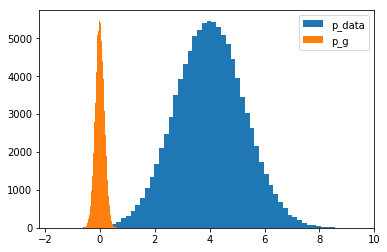

c:\users\ron\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


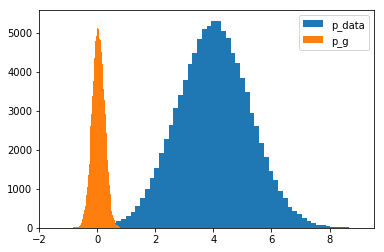

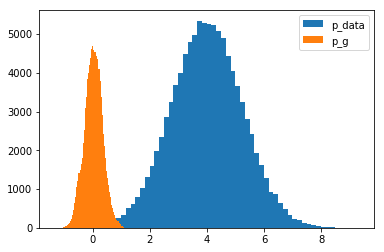

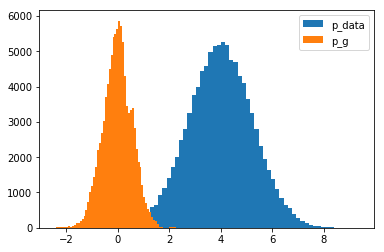

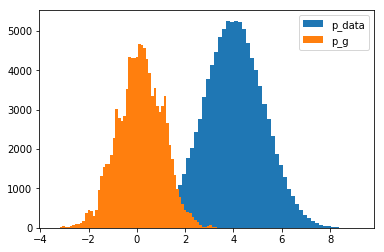

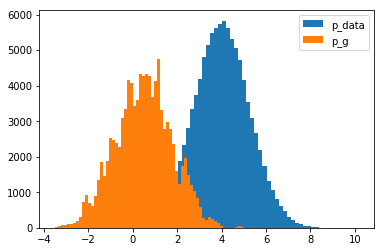

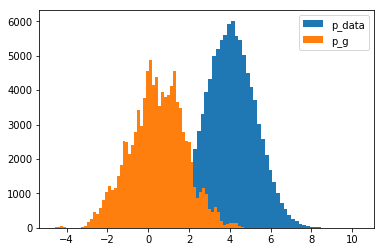

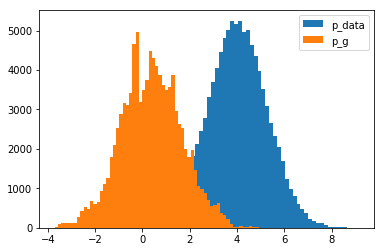

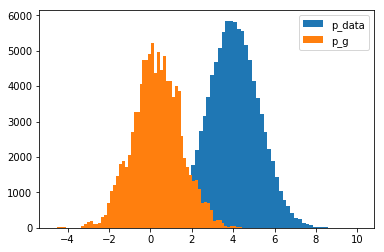

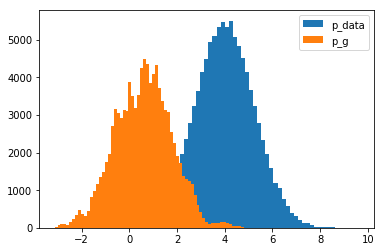

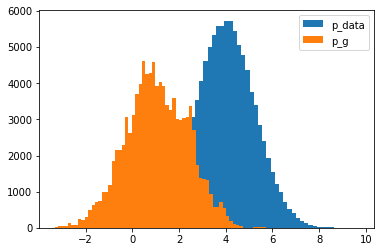

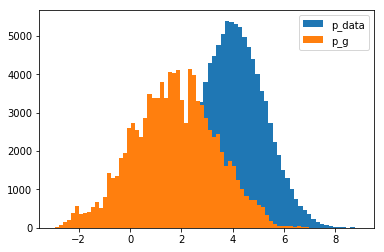

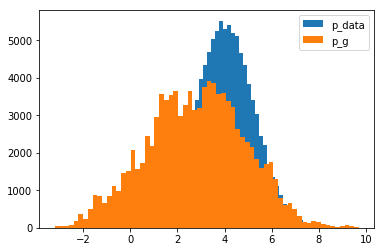

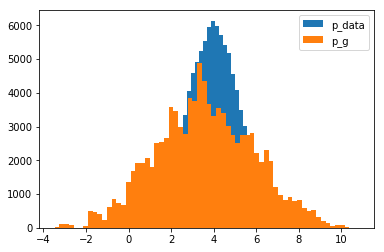

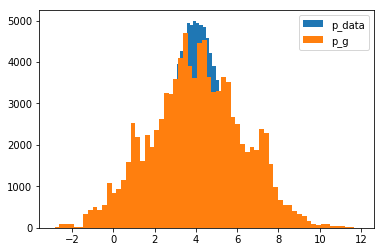

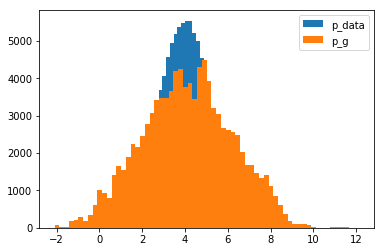

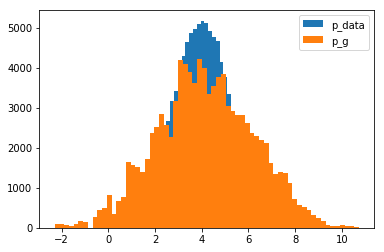

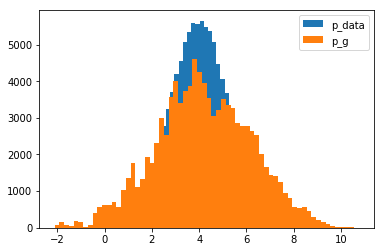

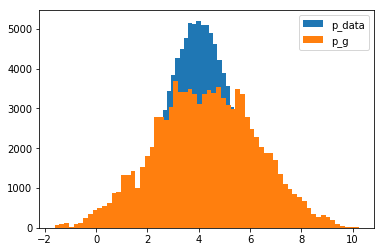

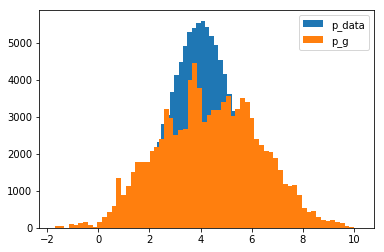

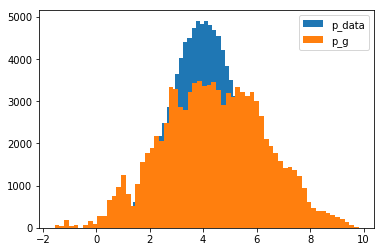

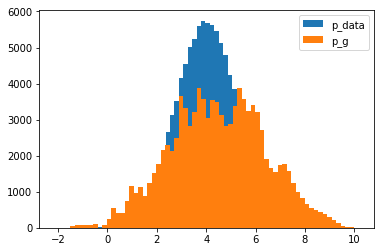

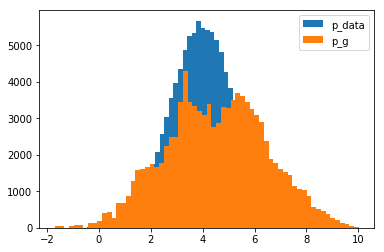

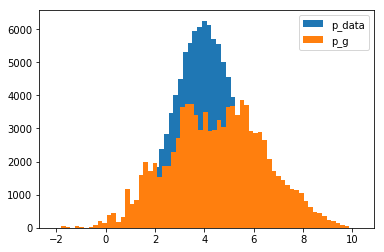

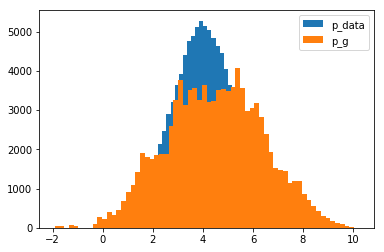

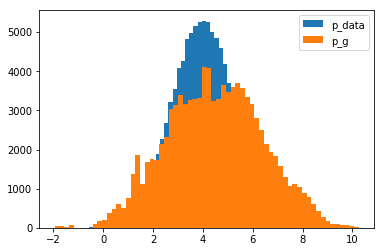

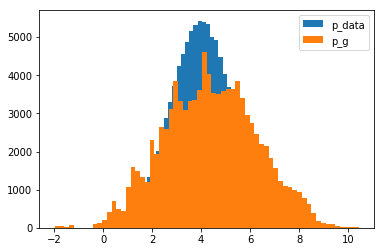

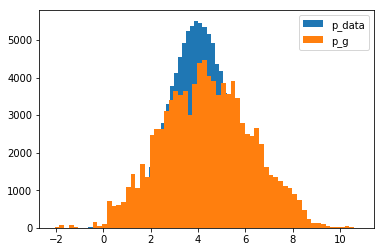

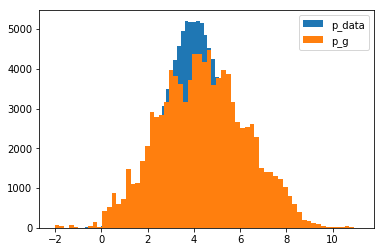

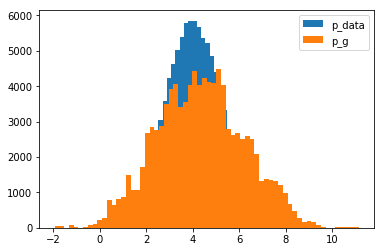

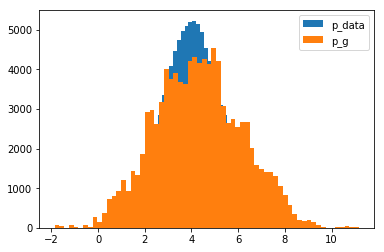

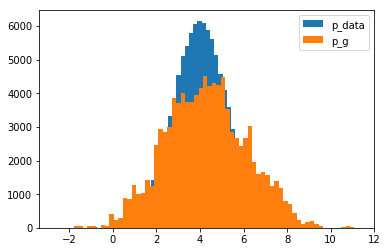

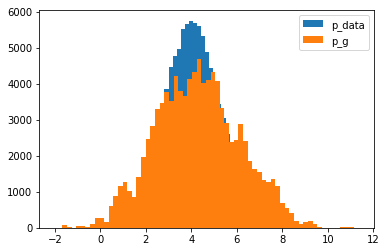

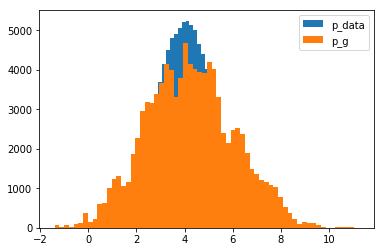

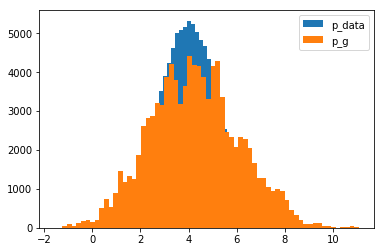

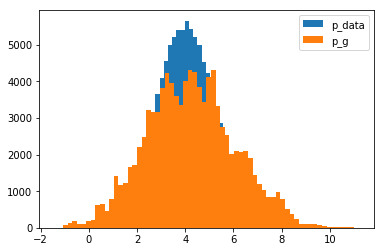

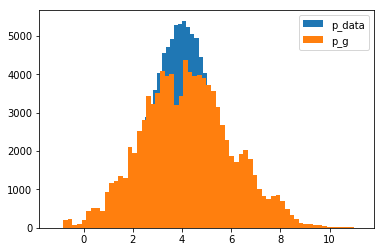

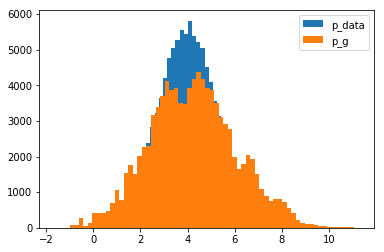

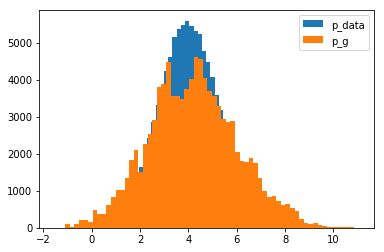

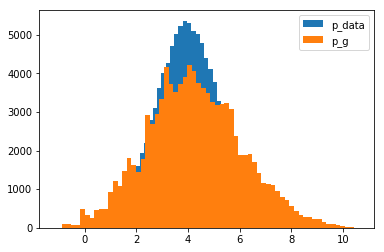

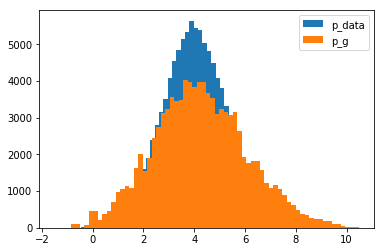

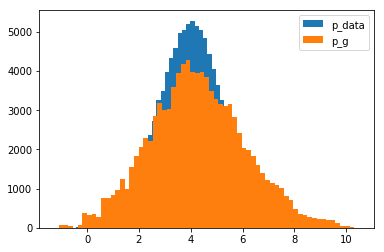

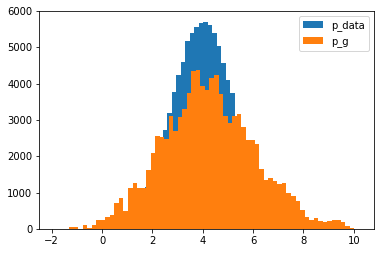

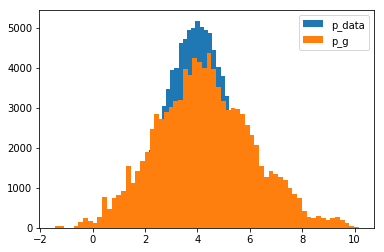

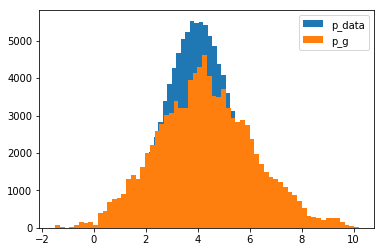

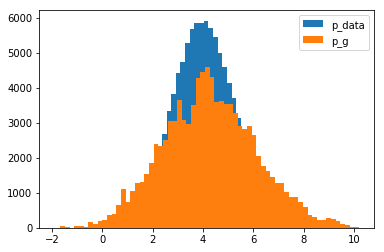

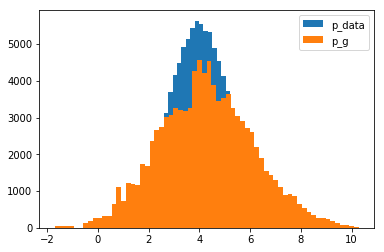

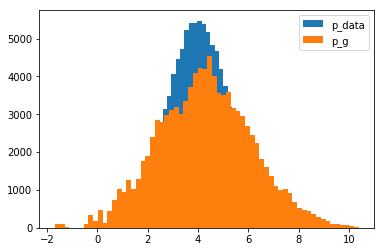

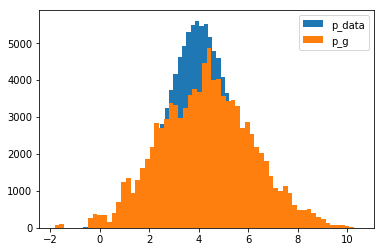

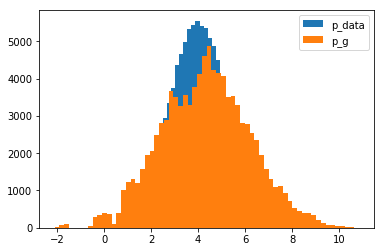

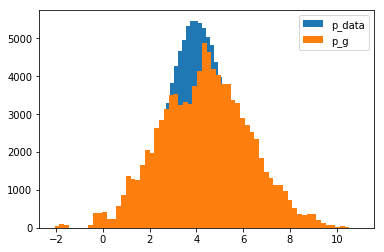

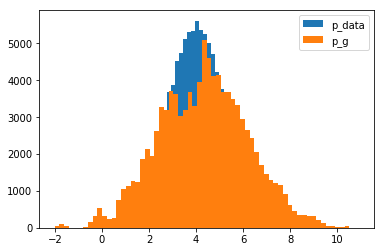

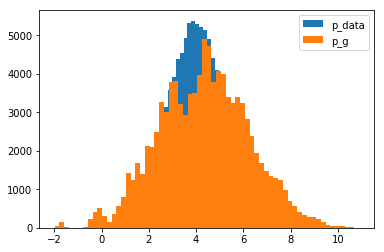

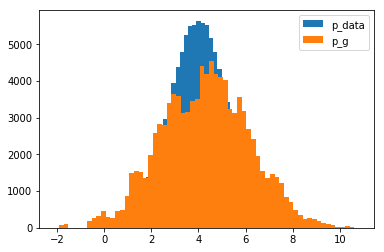

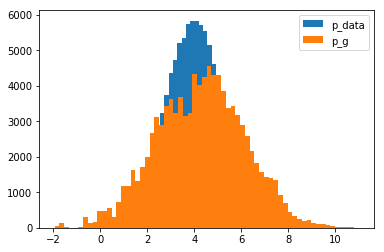

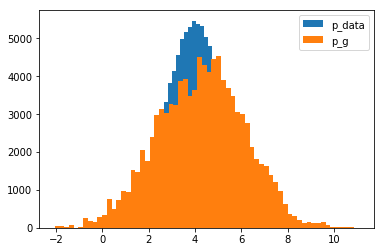

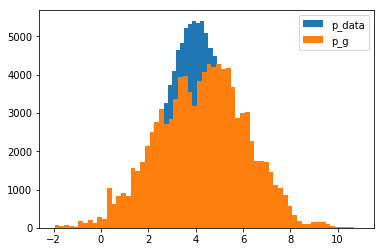

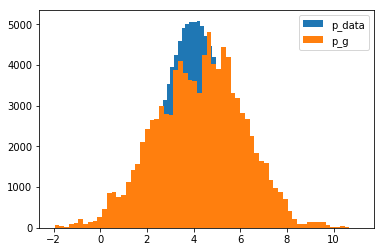

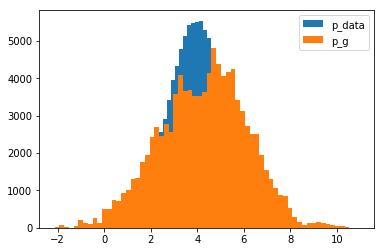

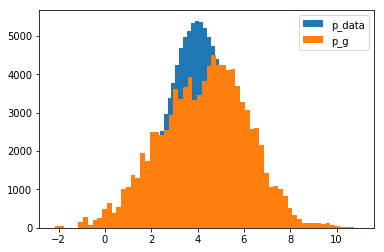

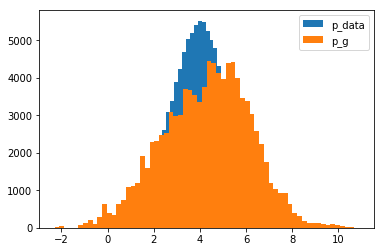

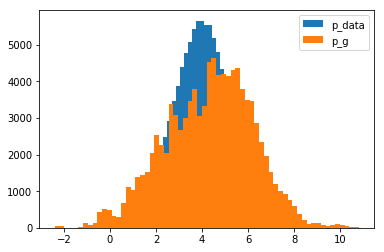

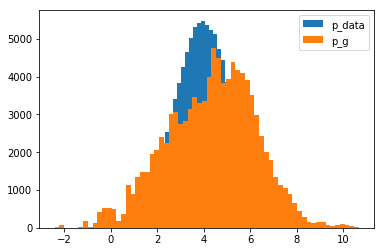

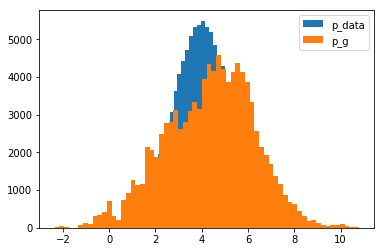

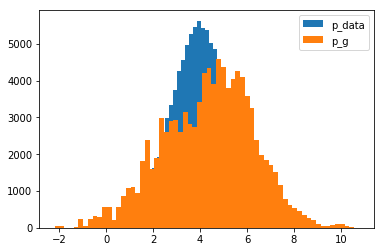

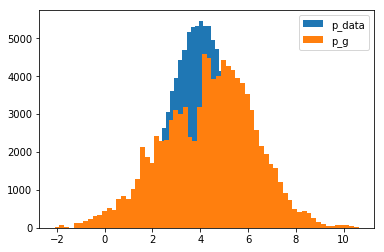

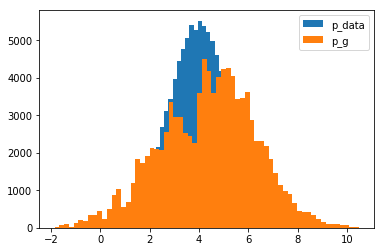

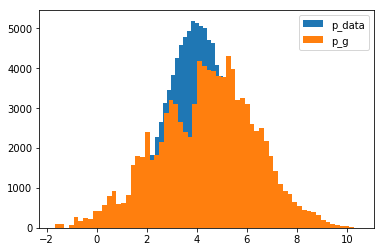

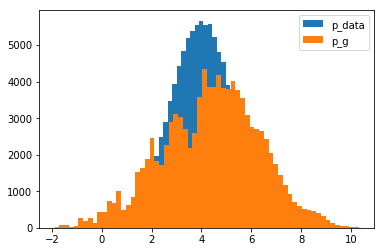

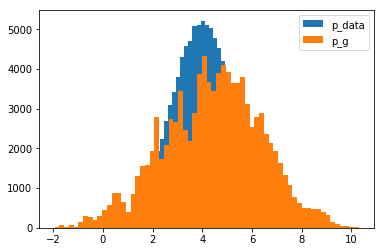

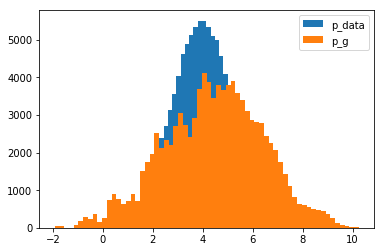

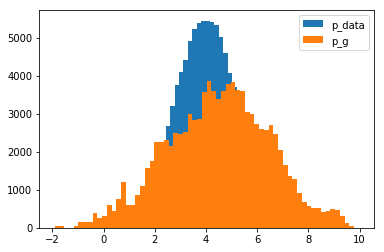

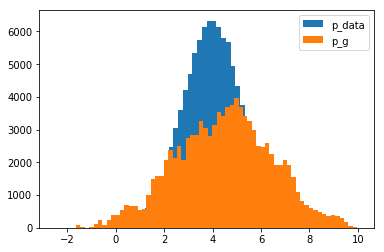

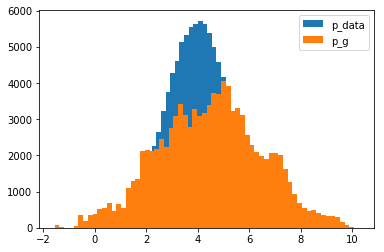

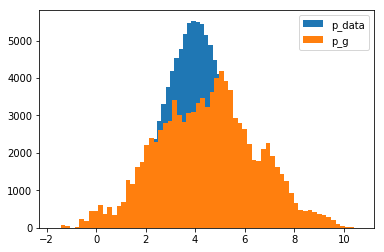

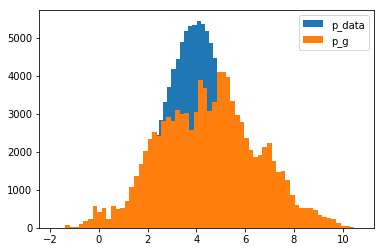

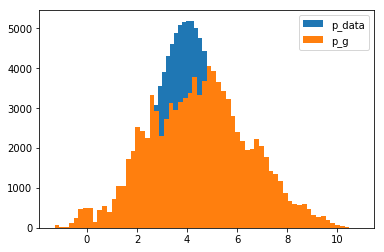

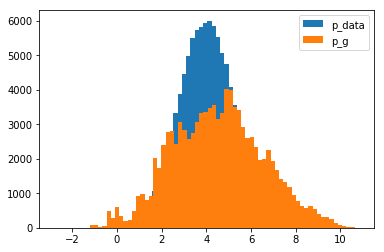

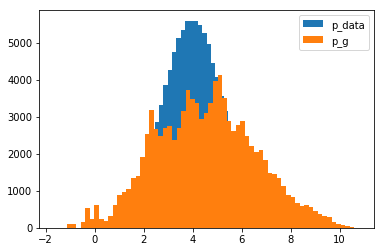

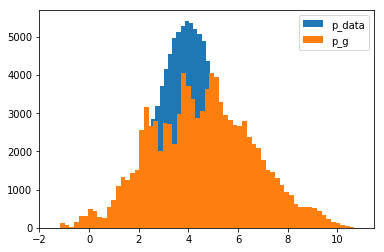

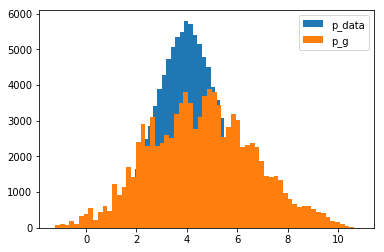

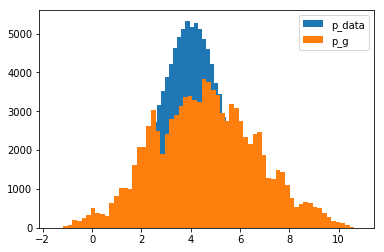

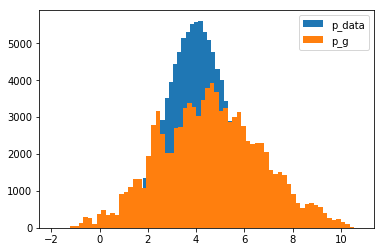

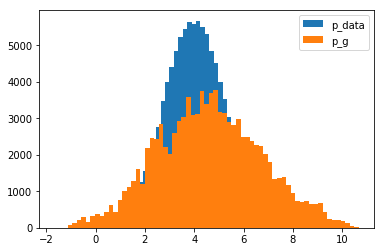

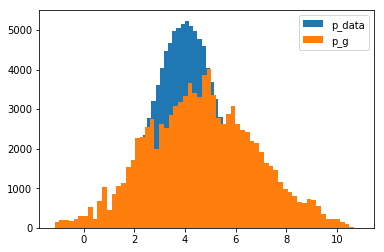

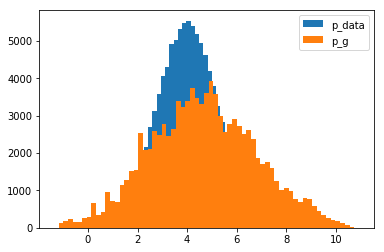

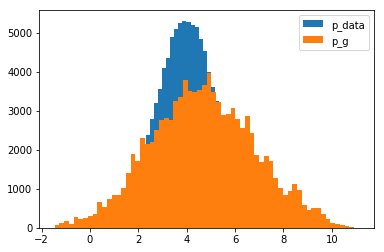

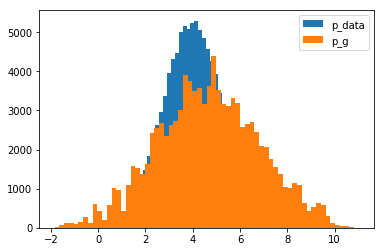

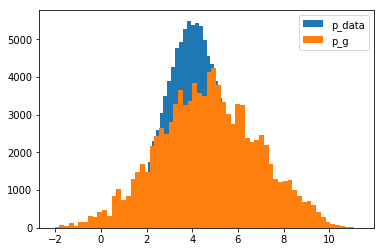

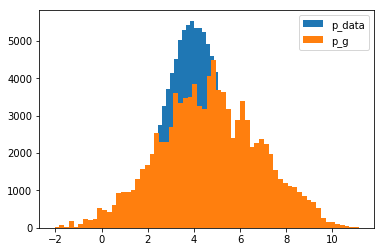

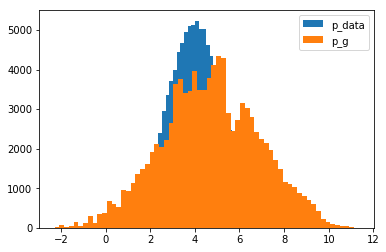

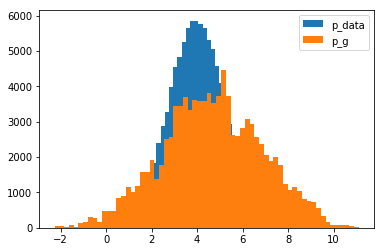

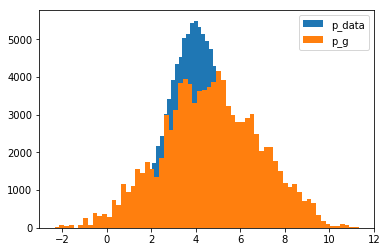

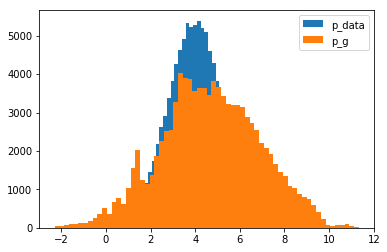

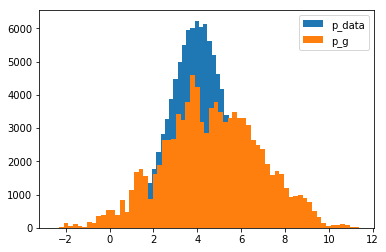

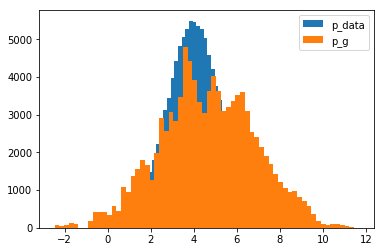

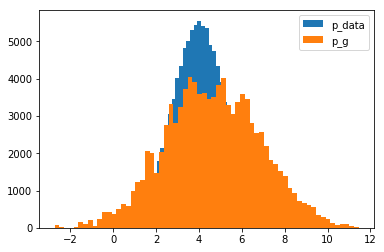

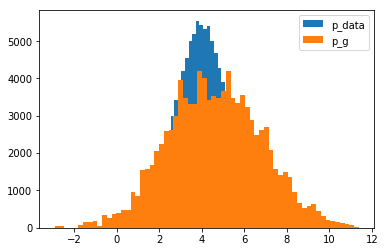

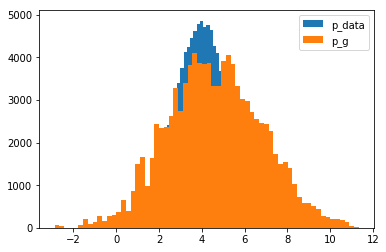

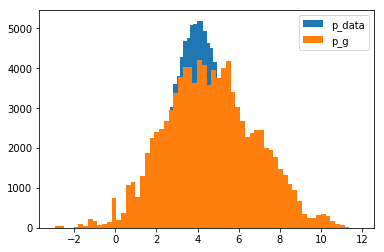

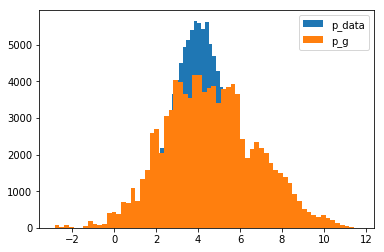

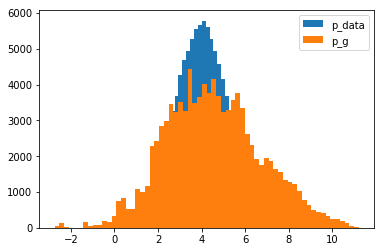

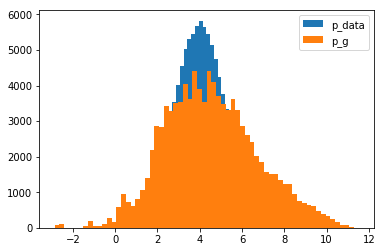

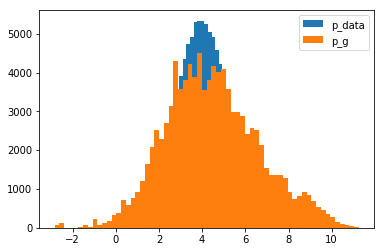

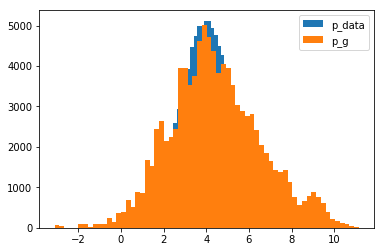

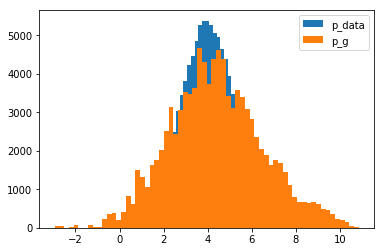

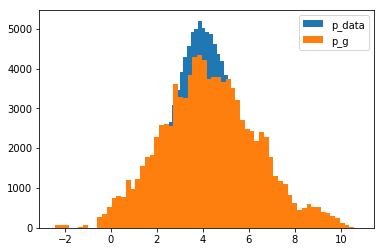

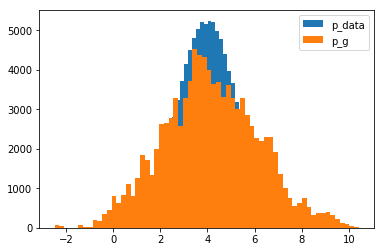

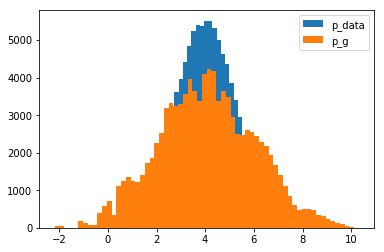

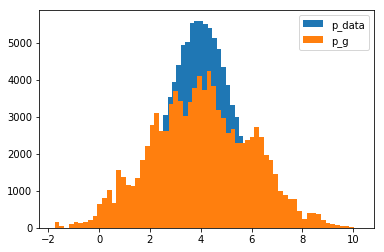

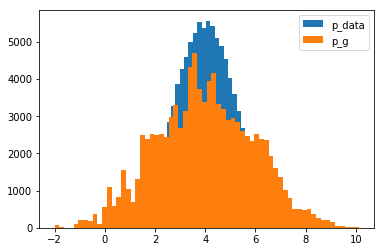

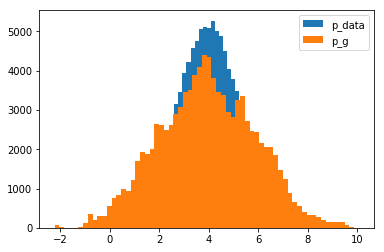

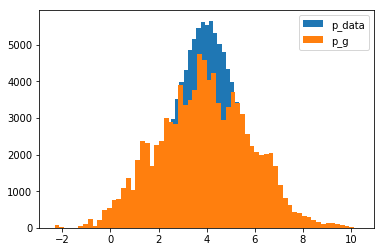

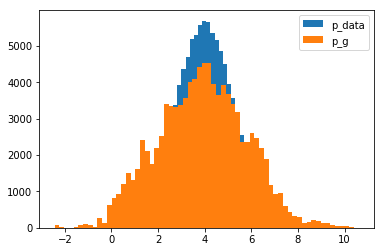

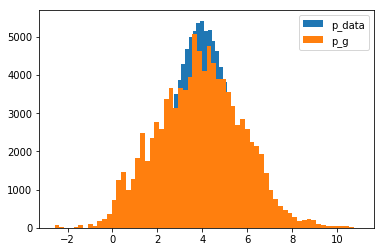

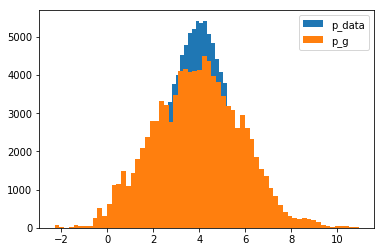

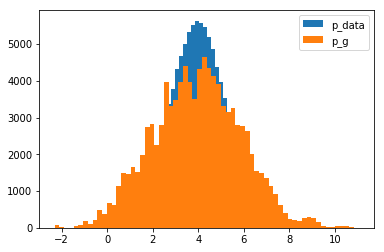

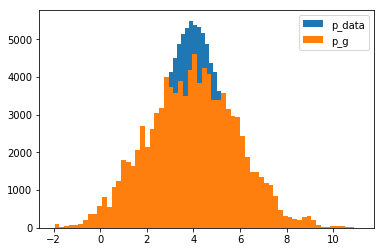

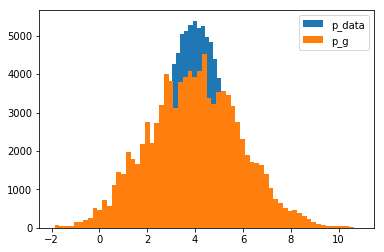

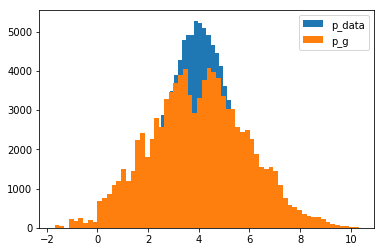

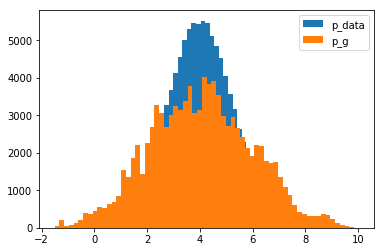

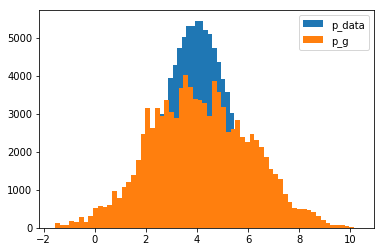

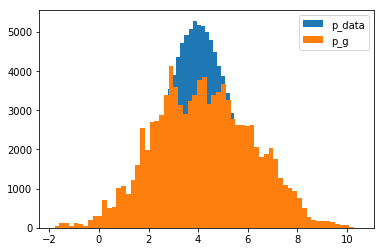

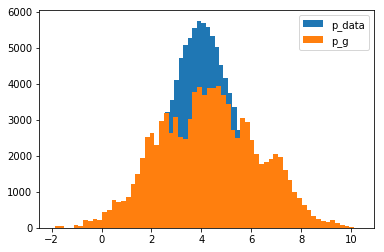

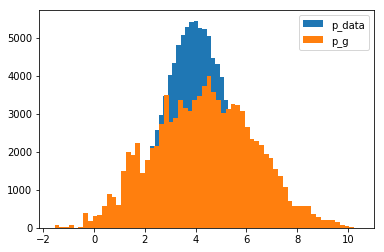

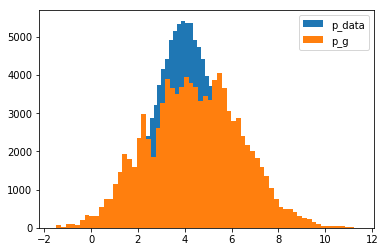

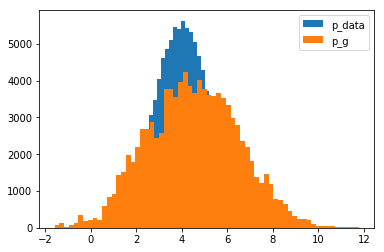

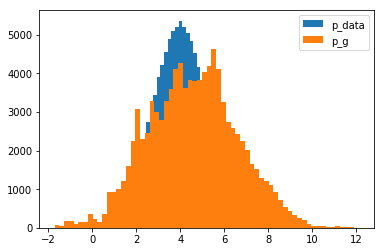

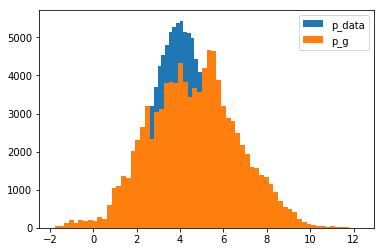

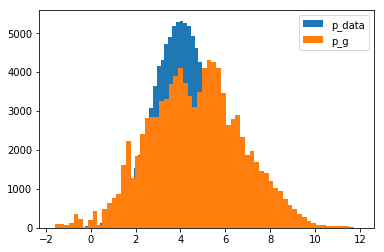

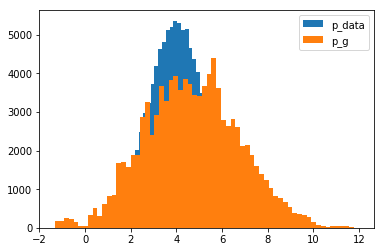

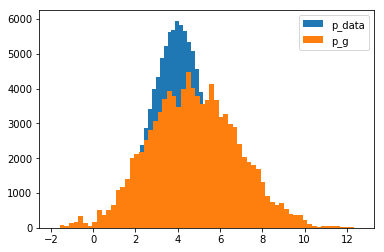

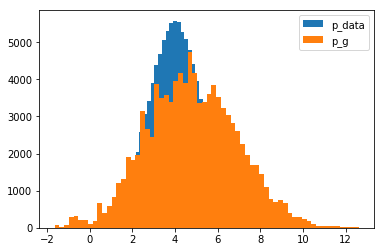

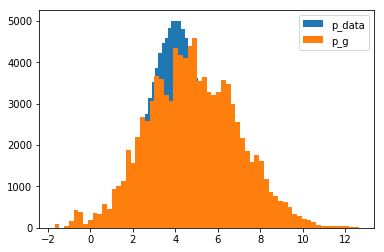

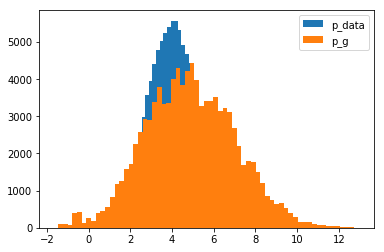

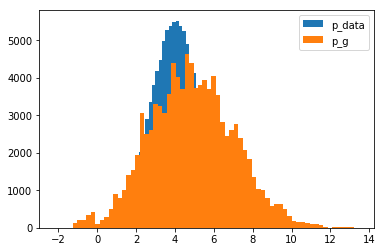

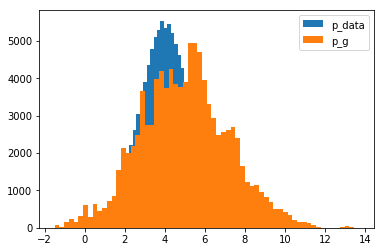

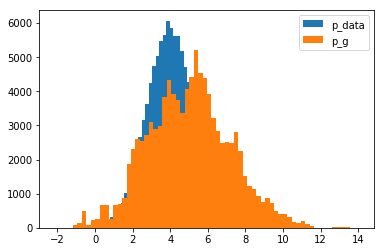

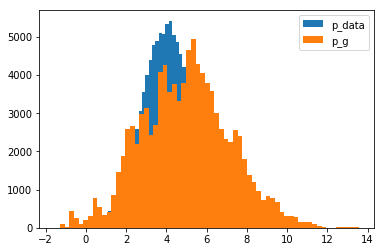

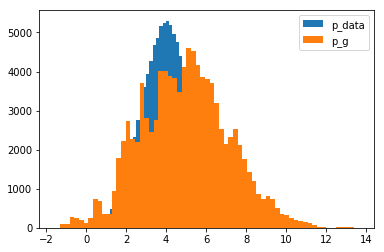

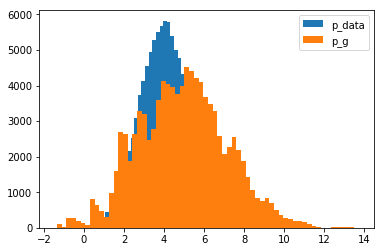

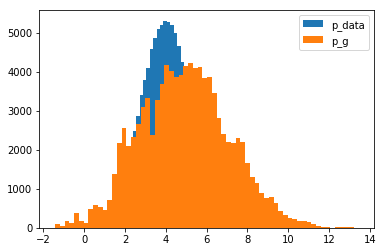

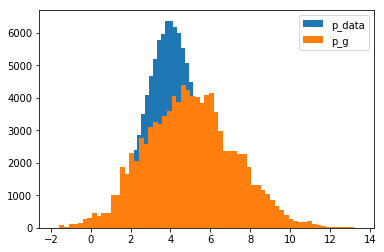

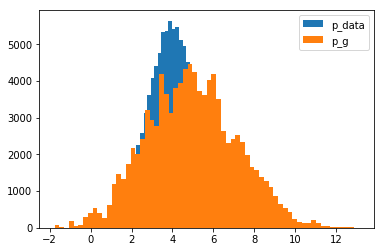

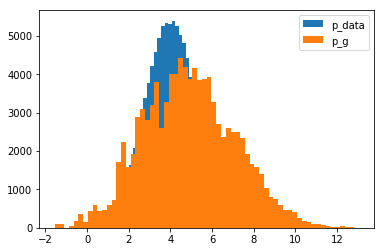

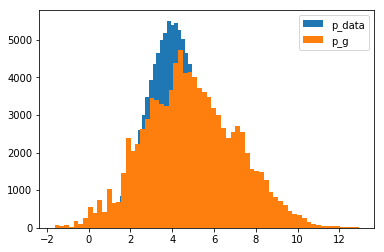

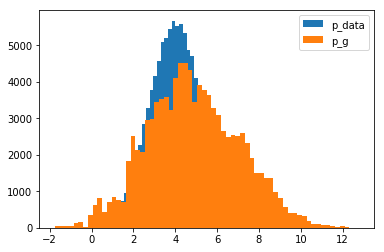

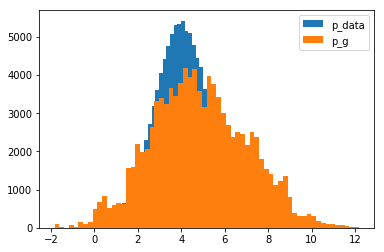

KeyboardInterrupt: 

In [83]:
m = 100

num_train_iter = 10000
num_d_train_iter = 1

verbosity = 0

# The noise prior p_z is chosen to be uniform
# Let x denote the number of noise samples to obtain
p_z = lambda x: np.random.uniform(size=(x, n))

p_g = lambda x: G.predict(p_z(x))

for i in range(num_train_iter):
    if (i % 10) == 0:
        show_distributions([p_data, p_g], ['p_data', 'p_g'])

    for k in range(num_d_train_iter):
        # Sample minibatch of m noise samples {z_1,..,z_m} from noise prior p_g(z)
        zs = p_g(m)
        # Sample minibatch of m examples {x_1,..,..x_m} from data generating distribution p_data(x)
        ds = p_data(m)
        # Update the discriminator using SGD
        D.model.fit(zs, np.zeros(m), verbose=verbosity)
        D.model.fit(ds, np.ones(m), verbose=verbosity)

    # Sample minibatch of m noise samples {z_1,..,z_m} from noise prior p_z(z)
    zs = p_z(m)
    # Update generator using SGD
    DG.fit(zs, np.ones(m), verbose=verbosity)
    
    